#Fundamentals of Machine Learning

##Binary classification of memorable images with CNN and GIST features using Random Forest Classification 

This notebook presents the implementation of a Random Forest Classifier to classify a dataset of features of memorable or not memorable images.

Notebook plan:
1. Imports and data gathering
2. The first model
3. Impact of data pre-processing
4. Impact of classifier hyperparameters (e.g max_depth)
5. Final model and evaluation
6. Making the test predictions
7. Brief evaluation of other classifiers

###1. Imports and data gathering

In [278]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tabulate import tabulate
from operator import itemgetter
import warnings

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, SelectFromModel, chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [236]:
drive.mount('/content/drive')

trainingdata1=pd.read_csv('/content/drive/My Drive/UNI/Machine learning report/training1.csv')
trainingdata2=pd.read_csv('/content/drive/My Drive/UNI/Machine learning report/training2.csv')
testdata=pd.read_csv('/content/drive/My Drive/UNI/Machine learning report/test.csv')

feature_names = list(trainingdata1.columns)[:-2] #Get feature names, same for trainingdata1 and trainingdata2

print('Number of samples in trainingdata1:', len(trainingdata1))
print('Number of samples in trainingdata2:', len(trainingdata2))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of samples in trainingdata1: 600
Number of samples in trainingdata2: 2800


In [280]:
#Here we create trainingdata3, which is the vertical stack of trainingdata1 and trainingdata2
#This means it is a mix of our two datasets

trainingdata3 = pd.concat([trainingdata1, trainingdata2], axis=0, ignore_index=True)
print('Number of samples in trainingdata3:',len(trainingdata3))

Number of samples in trainingdata3: 3400


###2. The first model

In [281]:
#Function to get the 4 evaluation metrics of a model
def get_metrics(model, X_val,Y_val):
  predictions = model.predict(X_val) #first make the predictions

  #Getting each metric with the predictions and the ground-truths
  accuracy = accuracy_score(Y_val,predictions)
  precision = precision_score(Y_val,predictions)
  recall = recall_score(Y_val,predictions)
  f1 = f1_score(Y_val,predictions)

  return accuracy, precision, recall, f1

Here we implement a Random Forest Classifier (RFC) without any data pre-processing. It is trained on trainingdata1 as it does not require any data pre-processing since it has no missing values. This serves as an example of how we trained and evaluated the rest of the models 

In [5]:
#Getting X and Y data
X = trainingdata1.iloc[:,:-2] #Features
Y = trainingdata1.iloc[:,-2:-1] #Labels (0 or 1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5) #Splitting the data

In [6]:
# Implementing a Random Forest Classifier and fitting it to our training data
rfc = RandomForestClassifier().fit(X_train, Y_train.values.ravel())

In [7]:
# Evaluating it
predictions = rfc.predict(X_val)
accuracy = accuracy_score(Y_val,predictions)
print('The accuracy of this RFC is', accuracy)

The accuracy of this RFC is 0.73


The random nature of RFCs means they might produce different classifications even when fitted with the same data parameters. We overcome this by re-splitting the data, re-training it, and re-evaluating and making an average of the total accuracy.

In [8]:
# Evaluating the baseline model
accuracy_total = 0
precision_total = 0
recall_total = 0
f1_total = 0

for i in range(10):
  #Initialising and fitting
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5) #Splitting the data
  rfc = RandomForestClassifier(n_estimators=450, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=6, n_jobs=-1).fit(X_train, Y_train.values.ravel())

  #Evaluating
  accuracy, precision, recall, f1 = get_metrics(rfc,X_val,Y_val)
  accuracy_total += accuracy
  precision_total += precision
  recall_total += recall
  f1_total += f1

baseline_accuracy = accuracy_total/10
baseline_precision = precision_total/10
baseline_recall = recall_total/10
baseline_f1 = f1_total/10
baseline_data = [["Accuracy", baseline_accuracy], 
                 ["Precision", baseline_precision], 
                 ["Recall", baseline_recall], 
                 ["F1", baseline_f1]]
  
print('The metrics of our first RFC model averaged over 10 runs:')
print(tabulate(baseline_data, headers=['Metric','Value'], tablefmt="fancy_grid"))

The metrics of our baseline RFC averaged over 10 runs:
╒═══════════╤══════════╕
│ Metric    │    Value │
╞═══════════╪══════════╡
│ Accuracy  │ 0.761    │
├───────────┼──────────┤
│ Precision │ 0.745488 │
├───────────┼──────────┤
│ Recall    │ 0.746156 │
├───────────┼──────────┤
│ F1        │ 0.744346 │
╘═══════════╧══════════╛


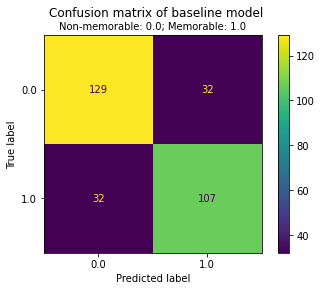

In [9]:
#Plotting the baseline model's confusion matrix
predictions = rfc.predict(X_val)
cm = confusion_matrix(Y_val, predictions, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)
disp.plot()
plt.suptitle('Confusion matrix of baseline model')
plt.title('Non-memorable: 0.0; Memorable: 1.0',fontsize=10)
plt.show()

###3. Impact of data pre-processing

"Data pre-processing" is a synonym for "feature pre-processing" in our case as its the feature set that will change.

We will test the impact of the following feature pre-processing techniques on our baseline model:
- Imputing missing values with mean vs median of the features
- Training on normalised/standardised data
- Training on only CNN/GIST features
- Training on a subset of 'important' features
- Training on a subset of PCA features
- Training on only confident samples

**Filling in missing values with mean vs median of feature**

Our Random Forest Classification model cannot deal with missing values, so we have to replace them. Our solutions are the following:
- entirely remove the features with at least one missing value,
- fill in the missing values with the mean of the non-missing values in that feature,
- fill in the missing values with the median of the non-missing values in that feature. 

We cannot use the former as all columns have missing values. Therefore, we will compare the impact on the accuracy of our baseline RFC with data filled in with the mean vs the median.

The metrics of our RFC with missing values replaced with the mean averaged over 10 runs:
╒══════════╤══════════╕
│ Metric   │    Value │
╞══════════╪══════════╡
│ Accuracy │ 0.749941 │
├──────────┼──────────┤
│ F1       │ 0.733091 │
╘══════════╧══════════╛


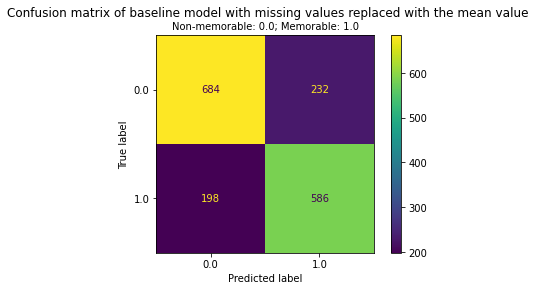

In [10]:
#RFC trained on trainingdata3 with missing values replaced with the mean

trainingdata3_NaNs_replaced_mean = trainingdata3.copy()

#Replacing the missing values
for feature_name in feature_names:
  trainingdata3_NaNs_replaced_mean[feature_name] = trainingdata3_NaNs_replaced_mean[feature_name].replace(np.NaN, trainingdata3_NaNs_replaced_mean[feature_name].mean())

#Creating our new X and Y data from the dataset with imputed values
X = trainingdata3_NaNs_replaced_mean.iloc[:,:-2] #Features
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1] #Labels (0 or 1)

#Evaluating a model trained on the missing values imputed with the mean and printing the average metrics
accuracy_total = 0
f1_total = 0
for i in range(10):
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5) #Splitting the data
  rfc = RandomForestClassifier(n_estimators=450, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=6, n_jobs=-1).fit(X_train, Y_train.values.ravel())
  accuracy, precision, recall, f1 = get_metrics(rfc,X_val,Y_val)
  accuracy_total += accuracy
  f1_total += f1

mean_replaced_accuracy = accuracy_total/10
mean_replaced_f1 = f1_total/10
mean_replaced_data = [["Accuracy", mean_replaced_accuracy], 
                      ["F1", mean_replaced_f1]]

print('The metrics of our RFC with missing values replaced with the mean averaged over 10 runs:')
print(tabulate(mean_replaced_data, headers=['Metric','Value'], tablefmt="fancy_grid"))

#Printing the Confusion Matrix of one of our RFCs trained on the missing values imputed with the mean
predictions = rfc.predict(X_val)
cm = confusion_matrix(Y_val, predictions, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)
disp.plot()
plt.suptitle('Confusion matrix of baseline model with missing values replaced with the mean value')
plt.title('Non-memorable: 0.0; Memorable: 1.0',fontsize=10)
plt.show()

The metrics of our RFC with missing values replaced with the median averaged over 10 runs:
╒══════════╤═════════╕
│ Metric   │   Value │
╞══════════╪═════════╡
│ Accuracy │ 0.742   │
├──────────┼─────────┤
│ F1       │ 0.72662 │
╘══════════╧═════════╛


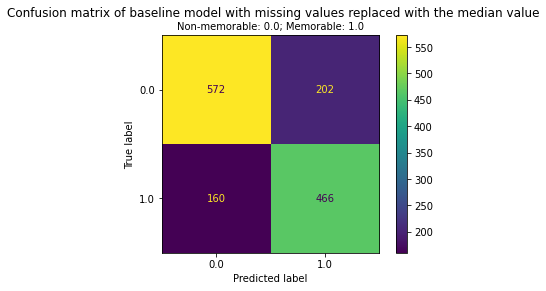

In [11]:
#RFC trained on trainingdata3 with missing values replaced with the median

trainingdata3_NaNs_replaced_median = trainingdata2.copy()

#Imputing the mising values with the median
for feature_name in feature_names:
  trainingdata3_NaNs_replaced_median[feature_name] = trainingdata3_NaNs_replaced_median[feature_name].replace(np.NaN, trainingdata3_NaNs_replaced_median[feature_name].median())

#Getting the new X and Y
X = trainingdata3_NaNs_replaced_median.iloc[:,:-2] #Features
Y = trainingdata3_NaNs_replaced_median.iloc[:,-2:-1] #Labels (0 or 1)

#Evaluating a model trained on this data and printing the average metrics
accuracy_total = 0
f1_total = 0
for i in range(10):
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5) #Splitting the data
  rfc = RandomForestClassifier(n_estimators=450, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=6, n_jobs=-1).fit(X_train, Y_train.values.ravel())
  accuracy, precision, recall, f1 = get_metrics(rfc,X_val,Y_val)
  accuracy_total += accuracy
  f1_total += f1

median_replaced_accuracy = accuracy_total/10
median_replaced_f1 = f1_total/10
median_replaced_data = [["Accuracy", median_replaced_accuracy], 
                        ["F1", median_replaced_f1]]

print('The metrics of our RFC with missing values replaced with the median averaged over 10 runs:')
print(tabulate(median_replaced_data, headers=['Metric','Value'], tablefmt="fancy_grid"))

#Printing the Confusion Matrix
predictions = rfc.predict(X_val)
cm = confusion_matrix(Y_val, predictions, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)
disp.plot()
plt.suptitle('Confusion matrix of baseline model with missing values replaced with the median value')
plt.title('Non-memorable: 0.0; Memorable: 1.0',fontsize=10)
plt.show()

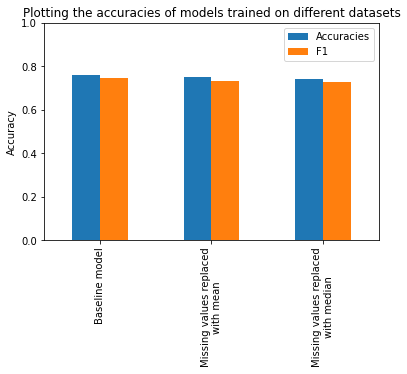

╒══════════╤══════════════════╤═════════════════════════════════╤═══════════════════════════════════╕
│ Metric   │   Baseline model │   Model data replaced with mean │   Model data replaced with median │
╞══════════╪══════════════════╪═════════════════════════════════╪═══════════════════════════════════╡
│ Accuracy │         0.761    │                        0.749941 │                           0.742   │
├──────────┼──────────────────┼─────────────────────────────────┼───────────────────────────────────┤
│ F1       │         0.745488 │                        0.733091 │                           0.72662 │
╘══════════╧══════════════════╧═════════════════════════════════╧═══════════════════════════════════╛


In [12]:
#Plot the difference in accuracy between the baseline classifier (trained on trainingdata1) and the mean and median replaced values

#Getting the data and putting it in a dataframe
model_names = ['Baseline model', 'Missing values replaced\nwith mean', 'Missing values replaced\nwith median']
accuracies = [baseline_accuracy, mean_replaced_accuracy, median_replaced_accuracy]
f1s = [baseline_f1, mean_replaced_f1, median_replaced_f1]
df = pd.DataFrame({'Accuracies': accuracies,
                   'F1':f1s}, index = model_names)

#Plotting the data
lines = df.plot.bar()
plt.ylim([0,1.0])
plt.ylabel('Accuracy')
plt.title('Plotting the accuracies of models trained on different datasets')
plt.show()


#Printing a table with the average metrics of each model, better for numerical comparison
data = [["Accuracy",baseline_data[0][1],mean_replaced_data[0][1],median_replaced_data[0][1]],
        ["F1", baseline_data[1][1],mean_replaced_data[1][1],median_replaced_data[1][1]]]
print(tabulate(data, headers=['Metric','Baseline model','Model data replaced with mean','Model data replaced with median'], tablefmt="fancy_grid"))

We found that the mean was the most accurate outcome, although the difference is quite small. Furthemore, the confusion matrices show that the three models trained on different data perform very similarly on classifying the memorable and non-memorable pictures.

Therefore, we will replace the missing values with the mean, as we found that it maximises the performance of our model.

**Training on normalised data**

Random Forest Classifiers are an ensemble of decision trees, and decision trees only care about the order of features, not their absolute values. Therefore, normalising our data should not have any impact on the performance of our RFC model. Here we test this out.

╒══════════╤═════════════════════════════════╤══════════════════════════════╕
│ Metric   │   Model without normalised data │   Model with normalised data │
╞══════════╪═════════════════════════════════╪══════════════════════════════╡
│ Accuracy │                        0.749941 │                     0.745529 │
├──────────┼─────────────────────────────────┼──────────────────────────────┤
│ F1       │                        0.733091 │                     0.726531 │
╘══════════╧═════════════════════════════════╧══════════════════════════════╛


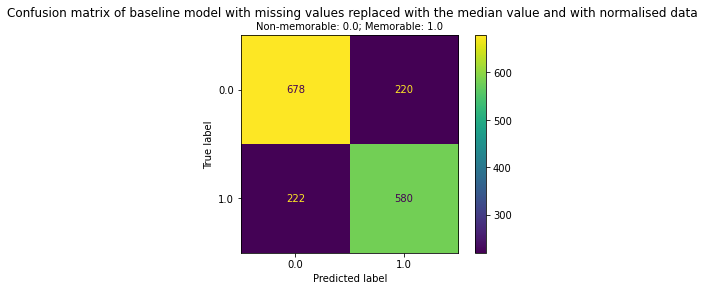

In [13]:
#RFC with normalised data
X = trainingdata3_NaNs_replaced_mean.iloc[:,:-2]
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1]

#Normalising the data
transformer = Normalizer().fit(X)
X = transformer.transform(X)

#Evaluating the model
accuracy_total = 0
f1_total = 0
for i in range(10):
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5)
  rfc = RandomForestClassifier(n_estimators=450, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=6, n_jobs=-1).fit(X_train,Y_train.values.ravel())
  accuracy, precision, recall, f1 = get_metrics(rfc,X_val,Y_val)
  accuracy_total += accuracy
  f1_total += f1

normalised_accuracy = accuracy_total/10
normalised_f1 = f1_total/10
normalised_data_metrics = [["Accuracy", normalised_accuracy], 
                        ["F1", normalised_f1]]

#Printing the average metrics in a table
data = [["Accuracy",mean_replaced_data[0][1],normalised_data_metrics[0][1]],
        ["F1", mean_replaced_data[1][1],normalised_data_metrics[1][1] ]]
print(tabulate(data, headers=['Metric','Model without normalised data','Model with normalised data'], tablefmt="fancy_grid"))

#Displaying the Confusion Matrix
predictions = rfc.predict(X_val)
cm = confusion_matrix(Y_val, predictions, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)
disp.plot()
plt.suptitle('Confusion matrix of baseline model with missing values replaced with the median value and with normalised data')
plt.title('Non-memorable: 0.0; Memorable: 1.0',fontsize=10)
plt.show()

Normalised data produced a very small decrease in accuracy from not normalising the data. This may be due to the smaller value changes in the features being erased by the normalisation, changing some decision tree structures. It also increaed the wrong predictions of the non-memorable pictures and increased the correct predictions of the memorable pictures by a very small margin. Nonetheless, the effect is negative on our accuracy and minimal, so we do not need to include it in our final model.

**Training on standardised data**

As for normalising, RFCs do not care about the absolute values of features, therefore, standardising shouldn't have an impact on the accuracy of the model.

╒══════════╤═══════════════════════════════════╤════════════════════════════════╕
│ Metric   │   Model without standardised data │   Model with standardised data │
╞══════════╪═══════════════════════════════════╪════════════════════════════════╡
│ Accuracy │                          0.749941 │                       0.747824 │
├──────────┼───────────────────────────────────┼────────────────────────────────┤
│ F1       │                          0.733091 │                       0.733141 │
╘══════════╧═══════════════════════════════════╧════════════════════════════════╛


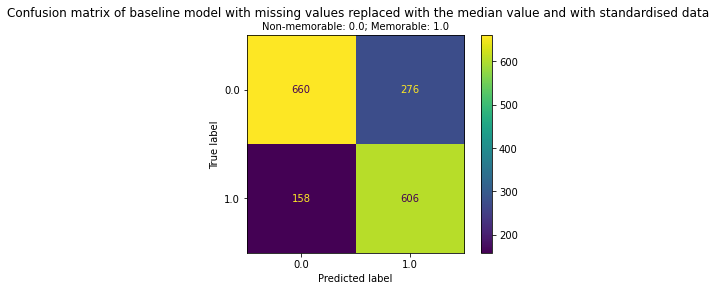

In [14]:
#RFC with standardised data

X = trainingdata3_NaNs_replaced_mean.iloc[:,:-2]
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1]

#Standardising the data
sc = StandardScaler()
X = sc.fit_transform(X)

#Evaluating the model with the data standardisede
accuracy_total = 0
f1_total = 0
for i in range(10):
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5)
  rfc = RandomForestClassifier(n_estimators=450, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=6, n_jobs=-1).fit(X_train,Y_train.values.ravel())
  accuracy, precision, recall, f1 = get_metrics(rfc,X_val,Y_val)
  accuracy_total += accuracy
  f1_total += f1

standardised_accuracy = accuracy_total/10
standardised_f1 = f1_total/10
standardised_data_metrics = [["Accuracy", standardised_accuracy], 
                        ["F1", standardised_f1]]

#Printing metrics 
data = [["Accuracy",mean_replaced_data[0][1],standardised_data_metrics[0][1]],
        ["F1", mean_replaced_data[1][1],standardised_data_metrics[1][1] ]]
print(tabulate(data, headers=['Metric','Model without standardised data','Model with standardised data'], tablefmt="fancy_grid"))

#Displaying the Confusion Matrix
predictions = rfc.predict(X_val)
cm = confusion_matrix(Y_val, predictions, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)
disp.plot()
plt.suptitle('Confusion matrix of baseline model with missing values replaced with the median value and with standardised data')
plt.title('Non-memorable: 0.0; Memorable: 1.0',fontsize=10)
plt.show()

Training our model on standardised data seems to have slightly decreased its accuracy and made it worse at classifying the memorable pictures. Since the impact is minimal and negative, we won't include standardisation of our data into our final model.

**Training on only the CNN features**

╒══════════╤═══════════════════════════════╤════════════════════════════════╕
│ Metric   │   Model with all the features │   Model with only CNN features │
╞══════════╪═══════════════════════════════╪════════════════════════════════╡
│ Accuracy │                      0.749941 │                       0.743765 │
├──────────┼───────────────────────────────┼────────────────────────────────┤
│ F1       │                      0.733091 │                       0.714746 │
╘══════════╧═══════════════════════════════╧════════════════════════════════╛


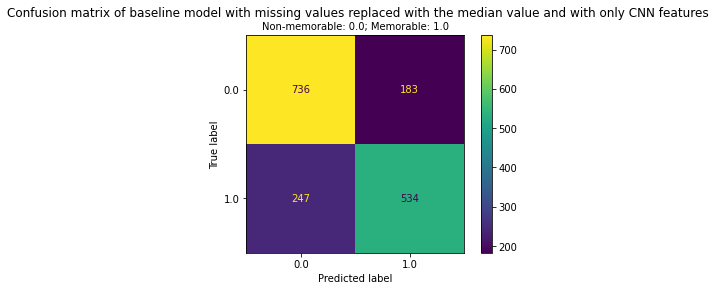

In [15]:
#RFC trained on only the CNN features

X = trainingdata3_NaNs_replaced_mean.iloc[:,0:-514] #Only the CNN features
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1]

#Evaluating model trained on only the CNN features
accuracy_total = 0
f1_total = 0
for i in range(10):
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5)
  rfc = RandomForestClassifier(n_estimators=450, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=6, n_jobs=-1).fit(X_train,Y_train.values.ravel())
  accuracy, precision, recall, f1 = get_metrics(rfc,X_val,Y_val)
  accuracy_total += accuracy
  f1_total += f1

CNN_features_accuracy = accuracy_total/10
CNN_features_f1 = f1_total/10
CNN_features_data_metrics = [["Accuracy", CNN_features_accuracy], 
                        ["F1", CNN_features_f1]]

#Printing the average metrics into a table
data = [["Accuracy",mean_replaced_data[0][1],CNN_features_data_metrics[0][1]],
        ["F1", mean_replaced_data[1][1],CNN_features_data_metrics[1][1] ]]
print(tabulate(data, headers=['Metric','Model with all the features','Model with only CNN features'], tablefmt="fancy_grid"))

#Displaying the Confusion Matrix
predictions = rfc.predict(X_val)
cm = confusion_matrix(Y_val, predictions, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)
disp.plot()
plt.suptitle('Confusion matrix of baseline model with missing values replaced with the median value and with only CNN features')
plt.title('Non-memorable: 0.0; Memorable: 1.0',fontsize=10)
plt.show()

Training on our model on only the CNN features has made it more accurate on predicting the non-memorable pictures, and worse on predicting the memorable ones. We do get a slight decrease in accuracy and F1. Therefore, we will not only train our model on CNN features. 

**Training on only the GIST features**

╒══════════╤═══════════════════════════════╤═════════════════════════════════╕
│ Metric   │   Model with all the features │   Model with only GIST features │
╞══════════╪═══════════════════════════════╪═════════════════════════════════╡
│ Accuracy │                      0.749941 │                        0.678412 │
├──────────┼───────────────────────────────┼─────────────────────────────────┤
│ F1       │                      0.733091 │                        0.664507 │
╘══════════╧═══════════════════════════════╧═════════════════════════════════╛


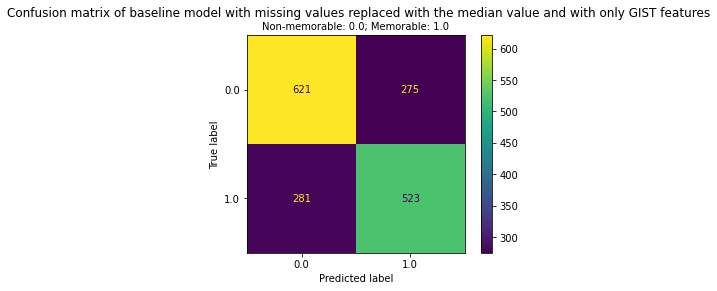

In [16]:
#RFC trained on only the GIST features

X = trainingdata3_NaNs_replaced_mean.iloc[:,4096:-2] #Only the GIST features
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1]

#Evaluating the model trained on only the GIST features
accuracy_total = 0
f1_total = 0
for i in range(10):
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5)
  rfc = RandomForestClassifier(n_estimators=450, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=6, n_jobs=-1).fit(X_train,Y_train.values.ravel())
  accuracy, precision, recall, f1 = get_metrics(rfc,X_val,Y_val)
  accuracy_total += accuracy
  f1_total += f1

GIST_features_accuracy = accuracy_total/10
GIST_features_f1 = f1_total/10
GIST_features_data_metrics = [["Accuracy", GIST_features_accuracy], 
                        ["F1", GIST_features_f1]]

#Printing the average metrics of the model
data = [["Accuracy",mean_replaced_data[0][1],GIST_features_data_metrics[0][1]],
        ["F1", mean_replaced_data[1][1],GIST_features_data_metrics[1][1] ]]
print(tabulate(data, headers=['Metric','Model with all the features','Model with only GIST features'], tablefmt="fancy_grid"))

#Displaying the Confusion Matrix
predictions = rfc.predict(X_val)
cm = confusion_matrix(Y_val, predictions, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)
disp.plot()
plt.suptitle('Confusion matrix of baseline model with missing values replaced with the median value and with only GIST features')
plt.title('Non-memorable: 0.0; Memorable: 1.0',fontsize=10)
plt.show()

Training our model with only the GIST features has decreased its accuracy by 10%. The GIST features do no seem to have data that permits a clear separation between the memorable and non-memorable pictures. Therefore, we will not be training our final model on only the GIST features.

In [17]:
#Printing the comparison with only using CNN features and only using GIST features

print('Metric comparison of using all features, only CNN features and only GIST features for RFC classification')
data = [["Accuracy",mean_replaced_data[0][1],CNN_features_data_metrics[0][1],GIST_features_data_metrics[0][1]],
        ["F1", mean_replaced_data[1][1],CNN_features_data_metrics[1][1],GIST_features_data_metrics[1][1] ]]
print(tabulate(data, headers=['Metric','Model with all the features','Model with only CNN features','Model with only GIST features'], tablefmt="fancy_grid"))

Metric comparison of using all features, only CNN features and only GIST features for RFC classification
╒══════════╤═══════════════════════════════╤════════════════════════════════╤═════════════════════════════════╕
│ Metric   │   Model with all the features │   Model with only CNN features │   Model with only GIST features │
╞══════════╪═══════════════════════════════╪════════════════════════════════╪═════════════════════════════════╡
│ Accuracy │                      0.749941 │                       0.743765 │                        0.678412 │
├──────────┼───────────────────────────────┼────────────────────────────────┼─────────────────────────────────┤
│ F1       │                      0.733091 │                       0.714746 │                        0.664507 │
╘══════════╧═══════════════════════════════╧════════════════════════════════╧═════════════════════════════════╛


In the above table we can see clearly that we cannot exclude the CNN or GIST features in order to improve our model. Training our RFC on all the features (CNN and GIST) makes for a higher performing model.

**Training on the important features**

Random Forest Classifiers already choose features by their importance by making them the splitting points in their decision trees. This means that RFCs will look at which features are best at separating the data into two categories and use them in their decision trees. Therefore, only training an RFC on the important features shouldn't have any impact since it already performs that itself.

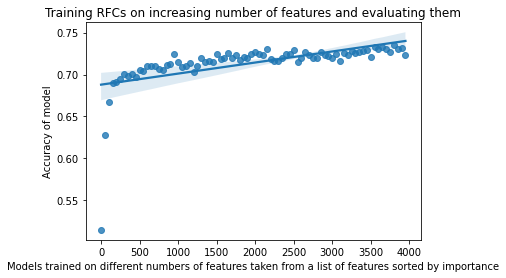

In [18]:
#RFCs trained on increasing number of important features

#Getting the initial data
X = trainingdata3_NaNs_replaced_mean.iloc[:,:-2]
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1]
rfc = RandomForestClassifier(n_estimators=450, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=6, n_jobs=-1).fit(X,Y.values.ravel())

#Finding the importance of each feature and sorting them in a list by most important to least important
features_sorted_by_importance = sorted([(index,score) for index, score in enumerate(rfc.feature_importances_)], key=lambda x:x[1])

#Training and evaluating models with different numbers of features taken from the list of importance
#The first model will only be trained on the 1st most important feature, the second model will be trained on the 51st most important features, and so on...
number_of_features_to_test = [i for i in range(1,4000,50)]
accuracy_by_number_of_features = []
for i in range(len(number_of_features_to_test)):
  #we train each model multiple times and average out the accuracy
  accuracy_total = 0
  top_features = [index for index, score in features_sorted_by_importance[:number_of_features_to_test[i]]]
  for j in range(3):
    X = trainingdata3_NaNs_replaced_mean.iloc[:,top_features]
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5)
    rfc = RandomForestClassifier(n_estimators=450, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=6, n_jobs=-1).fit(X_train,Y_train.values.ravel())
    accuracy_total += accuracy_score(Y_val,rfc.predict(X_val))
  accuracy_by_number_of_features.append(accuracy_total/3)

#Plotting the result of the evaluation
plt.title('Training RFCs on increasing number of features and evaluating them')
df = pd.DataFrame({'Models trained on different numbers of features taken from a list of features sorted by importance': number_of_features_to_test, 'Accuracy of model': accuracy_by_number_of_features})
sns.regplot(x='Models trained on different numbers of features taken from a list of features sorted by importance', y='Accuracy of model', data=df)
plt.show()
#add title to that plot

Best number of features (when sorted by importance) is: 3801
╒══════════╤═══════════════════════════════╤═══════════════════════════════════════════════════════════════════╕
│ Metric   │   Model with all the features │   Model with only some of the top features (sorted by importance) │
╞══════════╪═══════════════════════════════╪═══════════════════════════════════════════════════════════════════╡
│ Accuracy │                      0.749941 │                                                          0.732941 │
├──────────┼───────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ F1       │                      0.733091 │                                                          0.702785 │
╘══════════╧═══════════════════════════════╧═══════════════════════════════════════════════════════════════════╛


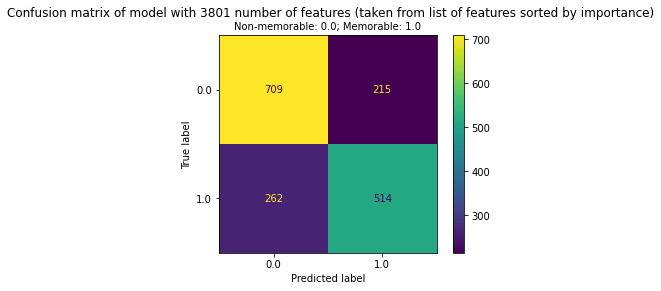

In [19]:
#Finding the number of important features to train our model on that has the highest average accuracy and evaluating it
best_num_of_features, accuracy = max(zip(number_of_features_to_test,accuracy_by_number_of_features),key=itemgetter(1))
print('Best number of features (when sorted by importance) is:', best_num_of_features)

#Only keeping the nth most important features, where n is defined by the model with the highest accuracy from our above evaluation
top_features = [index for index, score in features_sorted_by_importance[:best_num_of_features]]
X = trainingdata3_NaNs_replaced_mean.iloc[:,top_features]
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1]

#Evaluating the model
accuracy_total = 0
f1_total = 0
for i in range(10):
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5)
  rfc = RandomForestClassifier(n_estimators=450, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=6, n_jobs=-1).fit(X_train,Y_train.values.ravel())
  accuracy, precision, recall, f1 = get_metrics(rfc,X_val,Y_val)
  accuracy_total += accuracy
  f1_total += f1

top_features_importance_accuracy = accuracy_total/10
top_features_importance_f1 = f1_total/10
top_features_importance_data_metrics = [["Accuracy", top_features_importance_accuracy], 
                        ["F1", top_features_importance_f1]]

#Printing the model's evaluation's average metrics in a table
data = [["Accuracy",mean_replaced_data[0][1],top_features_importance_data_metrics[0][1]],
        ["F1", mean_replaced_data[1][1],top_features_importance_data_metrics[1][1] ]]
print(tabulate(data, headers=['Metric','Model with all the features','Model with only some of the top features (sorted by importance)'], tablefmt="fancy_grid"))

#Printing the Confusion Matrix
predictions = rfc.predict(X_val)
cm = confusion_matrix(Y_val, predictions, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)
disp.plot()
plt.suptitle('Confusion matrix of model with {} number of features (taken from list of features sorted by importance)'.format(best_num_of_features))
plt.title('Non-memorable: 0.0; Memorable: 1.0',fontsize=10)
plt.show()

By using the number of features (from a list of the features sorted by importance) that maximises our accuracy, we find an accuracy comparable to using all of the features. Furthermore, the RFC trained on that number of most important features seems a little better at prediction non-memorable pictures and worse at predicting memorable pictures. Our Random Forest Classifier did not need us to sort its features by importance for it to perform better, it actually made it worse.

**Training on Principal Component Analysis (PCA) features**

A feature having a high variance makes it more likely to be indicative of a sample's class. Therefore, we use PCA to sort our features by variance and see how many 'PCA features' (which is the list of features sorted by PCA) maximises our model's accuracy. We then the best 'PCA model' to our model trained on all features. As above when we sorted the features by importance, sorting the features by PCA should not have a positive impact on our model's accuracy since RFC already sorts the features on its own.

Note: We were limited in our number of components to test by our notebook's RAM availability. Fortunately, we were still able to get conclusive data about PCA's impact on our model.

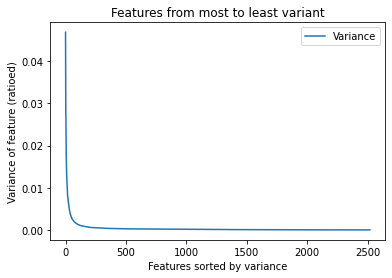

In [282]:
#Investigating the variance of features with PCA

X = trainingdata3_NaNs_replaced_mean.iloc[:,:-2]
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1]
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1)

#Need to scale features for PCA
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

#Getting the PCA features
pca = PCA(n_components=2520) #PCA will only accept a number of components that does not exceed our sample size
X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)

#Plotting the variance of features (by most variant)
df = pd.DataFrame({'Variance': pca.explained_variance_ratio_,})
lines = df.plot.line()
plt.title('Features from most to least variant')
plt.xlabel('Features sorted by variance')
plt.ylabel('Variance of feature (ratioed)')
plt.show()

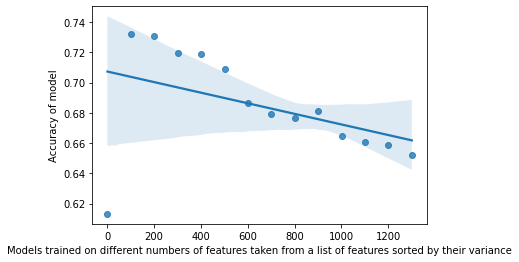

In [21]:
#RFCs trained on increasing number of features sorted by their variance

#Getting the data
X = trainingdata3_NaNs_replaced_mean.iloc[:,:-2]
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1]

#Scaling the features as PCA prefers that
sc = StandardScaler()
X = sc.fit_transform(X)

#Getting the number of components to test (which is number of features)
number_of_components_to_test = [i for i in range(1,1400,100)]

#Evaluating the models, each trained on a different number of components
accuracy_by_number_of_features = []
for i in range(len(number_of_components_to_test)):
  accuracy_total = 0 #we train each model multiple times and average out the accuracy
  
  for j in range(3):
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5)

    pca = PCA(n_components=number_of_components_to_test[i])
    X_train = pca.fit_transform(X_train)
    X_val = pca.transform(X_val)

    rfc = RandomForestClassifier(n_estimators=450, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=6, n_jobs=-1).fit(X_train,Y_train.values.ravel())
    accuracy_total += accuracy_score(Y_val,rfc.predict(X_val))
  accuracy_by_number_of_features.append(accuracy_total/3)

df = pd.DataFrame({'Models trained on different numbers of features taken from a list of features sorted by their variance': number_of_components_to_test, 'Accuracy of model': accuracy_by_number_of_features})
sns.regplot(x='Models trained on different numbers of features taken from a list of features sorted by their variance', y='Accuracy of model', data=df)
plt.show()

Best number of features (when sorted by variance) is: 101
Accuracy: 0.7319607843137255
╒══════════╤═══════════════════════════════╤════════════════════════════════════════════╕
│ Metric   │   Model with all the features │   Model with only some of the top features │
╞══════════╪═══════════════════════════════╪════════════════════════════════════════════╡
│ Accuracy │                      0.749941 │                                   0.664706 │
├──────────┼───────────────────────────────┼────────────────────────────────────────────┤
│ F1       │                      0.733091 │                                   0.617941 │
╘══════════╧═══════════════════════════════╧════════════════════════════════════════════╛


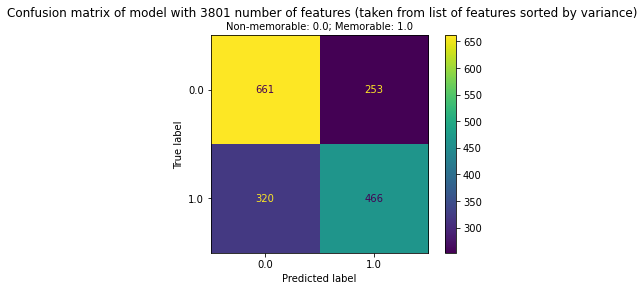

In [22]:
#Finding the number of most variant (PCA) features to train our model on that has the highest average accuracy and evaluating it
best_num_of_variant_features, accuracy = max(zip(number_of_components_to_test,accuracy_by_number_of_features),key=itemgetter(1))
print('Best number of features (when sorted by variance) is:', best_num_of_variant_features)
print('Accuracy:', accuracy)

#Getting the nth best features, n being defined by the model with the best accuracy's number of components
top_features = [index for index, score in features_sorted_by_importance[:best_num_of_variant_features]]
X = trainingdata3_NaNs_replaced_mean.iloc[:,top_features]
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1]

#Evaluating that model
accuracy_total = 0
f1_total = 0
for i in range(10):
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5)
  rfc = RandomForestClassifier(n_estimators=450, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=6, n_jobs=-1).fit(X_train,Y_train.values.ravel())
  accuracy, precision, recall, f1 = get_metrics(rfc,X_val,Y_val)
  accuracy_total += accuracy
  f1_total += f1

top_features_PCA_accuracy = accuracy_total/10
top_features_PCA_f1 = f1_total/10
top_features_PCA_data_metrics = [["Accuracy", top_features_PCA_accuracy], 
                        ["F1", top_features_PCA_f1]]

#Printing the model's average metrics table
data = [["Accuracy",mean_replaced_data[0][1],top_features_PCA_data_metrics[0][1]],
        ["F1", mean_replaced_data[1][1],top_features_PCA_data_metrics[1][1] ]]
print(tabulate(data, headers=['Metric','Model with all the features','Model with only some of the top features'], tablefmt="fancy_grid"))

#Printing the model's Confusion Matrix
predictions = rfc.predict(X_val)
cm = confusion_matrix(Y_val, predictions, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)
disp.plot()
plt.suptitle('Confusion matrix of model with {} number of features (taken from list of features sorted by variance)'.format(best_num_of_features))
plt.title('Non-memorable: 0.0; Memorable: 1.0',fontsize=10)
plt.show()

We get similar resuslts as when we sorted our features by importance: the RFC performs worse than without sorting the features. Again, we will not be implementing this feature into our model.

**Training on confident data**

The samples in our data have a 'confidence' labelling. This represents how confident the labellers were that the label (memorable or non-memorable) attributed to the sample is correct. Confident is 1.0, unconfident is 0.66. The idea here is that the confident data would have better features than the non-confident ones as they are more clearly memorable or non-memorable pictures to the human labellers. Training our RFC model on confident data should improve it.

In [23]:
#Comparing the proportion of memorable and non-memorable pictures in all samples, confident samples and unconfident samples

#Counting proportion of memorable and non-memorable pictures in all samples
X = trainingdata3_NaNs_replaced_mean.iloc[:,:-2]
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1]
samples_memorable = X[trainingdata3_NaNs_replaced_mean['label'] == 1]
samples_unmemorable = X[trainingdata3_NaNs_replaced_mean['label'] == 0]
print('In the {} samples, {}% are memorable and {}% are non-memorable'.format(len(X), round(len(samples_memorable)*100/len(X)), round(len(samples_unmemorable)*100/len(X))))

#Counting proportion of memorable and non-memorable pictures in confident samples
confident_samples = X[trainingdata3_NaNs_replaced_mean['confidence'] == 1]
confident_samples_memorable = X[(trainingdata3_NaNs_replaced_mean['confidence'] == 1) & (trainingdata3_NaNs_replaced_mean['label'] == 1)]
confident_samples_non_memorable = X[(trainingdata3_NaNs_replaced_mean['confidence'] == 1) & (trainingdata3_NaNs_replaced_mean['label'] == 0)]
print('In the {} confident samples, {}% are memorable and {}% are non-memorable'.format(len(confident_samples), round(len(confident_samples_memorable)*100/len(confident_samples)), round(len(confident_samples_non_memorable)*100/len(confident_samples))))

#Counting proportion of memorable and non-memorable pictures in unconfident samples
unconfident_samples = X[trainingdata3_NaNs_replaced_mean['confidence'] == 0.66]
unconfident_samples_memorable = X[(trainingdata3_NaNs_replaced_mean['confidence'] == 0.66) & (trainingdata3_NaNs_replaced_mean['label'] == 1)]
unconfident_samples_non_memorable = X[(trainingdata3_NaNs_replaced_mean['confidence'] == 0.66) & (trainingdata3_NaNs_replaced_mean['label'] == 0)]
print('In the {} unconfident samples, {}% are memorable and {}% are non-memorable'.format(len(unconfident_samples), round(len(unconfident_samples_memorable)*100/len(unconfident_samples)), round(len(unconfident_samples_non_memorable)*100/len(unconfident_samples))))

In the 3400 samples, 46% are memorable and 54% are non-memorable
In the 899 confident samples, 48% are memorable and 52% are non-memorable
In the 2501 unconfident samples, 46% are memorable and 54% are non-memorable


In [24]:
#Demonstrating how to extract the confident samples for the training data

#We first get all of the data
X = trainingdata3_NaNs_replaced_mean.iloc[:,:-2]
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1]
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1)
print('Model trained on {} samples and validated on {} samples'.format(len(X_train),len(X_val)))

#Then we only keep the 'confident' ones in training
X_train = X_train[trainingdata3_NaNs_replaced_mean['confidence'] == 1]
Y_train = Y_train[trainingdata3_NaNs_replaced_mean['confidence'] == 1]
print('Number of rows went down from {} to {}'.format(len(X),len(X_train)))

#Training and evaluating a model on the confident data
rfc = RandomForestClassifier(n_estimators=450, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=6, n_jobs=-1).fit(X_train,Y_train.values.ravel())
print('The accuracy of an RFC only trained on the confident samples is', accuracy_score(Y_val,rfc.predict(X_val)))

Model trained on 3060 samples and validated on 340 samples
Number of rows went down from 3400 to 804


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


The accuracy of an RFC only trained on the confident samples is 0.7558823529411764


╒══════════╤════════════════════════════════╤═══════════════════════════════════════════╕
│ Metric   │   Model trained on all samples │   Model only trained on confident samples │
╞══════════╪════════════════════════════════╪═══════════════════════════════════════════╡
│ Accuracy │                       0.749941 │                                  0.743353 │
├──────────┼────────────────────────────────┼───────────────────────────────────────────┤
│ F1       │                       0.733091 │                                  0.729557 │
╘══════════╧════════════════════════════════╧═══════════════════════════════════════════╛


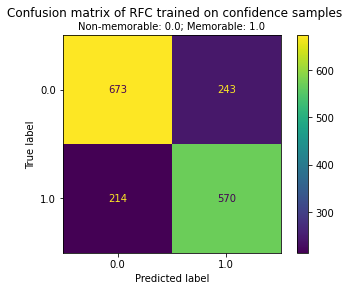

In [25]:
#Evaluating RFC trained only on confident samples

warnings.filterwarnings("ignore", category=UserWarning) #Lots os user warnings appear because of the re-indexing, we can ignore for clarity
                        
accuracy_total = 0
f1_total = 0
for i in range(10):
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5)
  X_train = X_train[trainingdata3_NaNs_replaced_mean['confidence'] == 1]
  Y_train = Y_train[trainingdata3_NaNs_replaced_mean['confidence'] == 1]
  rfc = RandomForestClassifier(n_estimators=450, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=6, n_jobs=-1).fit(X_train,Y_train.values.ravel())
  accuracy, precision, recall, f1 = get_metrics(rfc,X_val,Y_val)
  accuracy_total += accuracy
  f1_total += f1

confident_samples_accuracy = accuracy_total/10
confident_samples_f1 = f1_total/10
confident_samples_data_metrics = [["Accuracy", confident_samples_accuracy], 
                                  ["F1", confident_samples_f1]]

#Printing the average metrics of our classifier in a table
data = [["Accuracy",mean_replaced_data[0][1],confident_samples_data_metrics[0][1]],
        ["F1", mean_replaced_data[1][1],confident_samples_data_metrics[1][1] ]]
print(tabulate(data, headers=['Metric','Model trained on all samples','Model only trained on confident samples'], tablefmt="fancy_grid"))

#Printing the Confusion Matrix of our model
predictions = rfc.predict(X_val)
cm = confusion_matrix(Y_val, predictions, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)
disp.plot()
plt.suptitle('Confusion matrix of RFC trained on confidence samples')
plt.title('Non-memorable: 0.0; Memorable: 1.0',fontsize=10)
plt.show()

Training on confident samples has a sligthly lower accuracy and F1 than our baseline model that was trained on all samples. Furthemore, this model is worse at predicting the non-memorable pictures and better at predicting the memorable pictures. This indicates that the labellers agreed more on the labels of the memorable pictures than the non-memorable ones, by a slight margin. Therefore, we found no positive impact in training our RFC with more confident data, and won't include this pre-processing technique in our final model.



**Takeaways from data/sample pre-processing**

We have applied various forms of data/sample pre-processing techniques and evaluated our RFC model on it. We have found the impact for each to be minimal and rarely positive. We therefore won't include any of them in our final model.

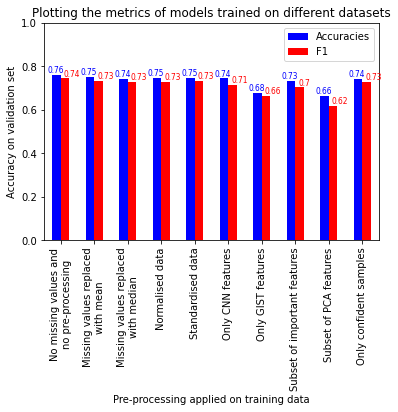

╒══════════╤═════════════════════════╤═══════════════════════════╤═══════════════════════════╤═══════════════════╤═════════════════════╤═════════════════════╤══════════════════════╤════════════════════════════════╤══════════════════════════╤══════════════════════════╕
│ Metric   │   No missing values and │   Missing values replaced │   Missing values replaced │   Normalised data │   Standardised data │   Only CNN features │   Only GIST features │   Subset of important features │   Subset of PCA features │   Only confident samples │
│          │       no pre-processing │                 with mean │               with median │                   │                     │                     │                      │                                │                          │                          │
╞══════════╪═════════════════════════╪═══════════════════════════╪═══════════════════════════╪═══════════════════╪═════════════════════╪═════════════════════╪══════════════════════╪════════════

In [231]:
#Plotting the accuracy and f1 of all of our pre-processed models we tested above for comparison
model_names = ['No missing values and\nno pre-processing',
               'Missing values replaced\nwith mean',
               'Missing values replaced\nwith median',
               'Normalised data',
               'Standardised data',
               'Only CNN features',
               'Only GIST features',
               'Subset of important features',
               'Subset of PCA features',
               'Only confident samples']
accuracies = [baseline_accuracy, mean_replaced_accuracy, median_replaced_accuracy, normalised_accuracy, standardised_accuracy, CNN_features_accuracy, GIST_features_accuracy, top_features_importance_accuracy, top_features_PCA_accuracy, confident_samples_accuracy]
f1s = [baseline_f1, mean_replaced_f1, median_replaced_f1, normalised_f1, standardised_f1, CNN_features_f1, GIST_features_f1, top_features_importance_f1, top_features_PCA_f1, confident_samples_f1]
df = pd.DataFrame({'Accuracies': accuracies,
                   'F1':f1s}, index = model_names)
lines = df.plot.bar(color=['blue','red'])
plt.ylim([0,1.0])
plt.ylabel('Accuracy on validation set')
plt.xlabel('Pre-processing applied on training data')
plt.title('Plotting the metrics of models trained on different datasets')

for i, v in enumerate(accuracies):
    plt.text(i-0.4, v + 0.01, str(round(v,2)),fontsize=7.5, color='blue')

for i, v in enumerate(f1s):
    plt.text(i+0.14 - 0.05, v + 0.01, str(round(v,2)),fontsize=7.5, color='red')

plt.show()


#Printing a table with the same data as in the plot above
data = [["Accuracy",baseline_accuracy, mean_replaced_accuracy, median_replaced_accuracy, normalised_accuracy, standardised_accuracy, CNN_features_accuracy, GIST_features_accuracy, top_features_importance_accuracy, top_features_PCA_accuracy, confident_samples_accuracy],
        ["F1",baseline_f1, mean_replaced_f1, median_replaced_f1, normalised_f1, standardised_f1, CNN_features_f1, GIST_features_f1, top_features_importance_f1, top_features_PCA_f1, confident_samples_f1 ]]
print(tabulate(data, headers=['Metric','No missing values and\nno pre-processing',
                                        'Missing values replaced\nwith mean',
                                        'Missing values replaced\nwith median',
                                        'Normalised data',
                                        'Standardised data',
                                        'Only CNN features',
                                        'Only GIST features',
                                        'Subset of important features',
                                        'Subset of PCA features',
                                        'Only confident samples'], tablefmt="fancy_grid"))

###4. Grid searching for the best Random Forest Classifiers hyperparameters

When implementing RFCs with the scikit-learn python package, there are many hyperparamaters to finetune. In this section, we will first do a randomgrid search to find a rough estimate of the parmeters where our RFC gets better. Then we will gridsearch through these parameters to find the most accurate model. It would have been preferable to do a gridsearch of all parameters but it takes a very long time to do so in practice, we traded performance for speed in this case.

The hyperparameters we will experiment with:
- Number of estimators (tree)
- Maximum number of feature to consider for a split
- Maximum depth of trees
- Minimum number of samples for leaf node
- Maximum number of feature to consider for a split
- Bootstrapping (random selection of samples for trees with replacement)

In [27]:
#Performing a random grid search

X = trainingdata3_NaNs_replaced_mean.iloc[:,:-2]
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1]
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5)

params = [{'n_estimators': [200, 400, 600, 800],
           'max_features': ['auto', 'sqrt'],
           'max_depth': [10,50,100,250],
           'min_samples_leaf': [1, 2, 4],
           'min_samples_split': [2, 5, 10],
           'bootstrap': [True, False]
           }]

rfc_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = params, n_iter = 50, cv = 2, verbose=2, n_jobs = -1)
rfc_random.fit(X_train,Y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions=[{'bootstrap': [True, False],
                                         'max_depth': [10, 50, 100, 250],
                                         'max_features': ['auto', 'sqrt'],
                                         'min_samples_leaf': [1, 2, 4],
                                         'min_samples_split': [2, 5, 10],
                                         'n_estimators': [200, 400, 600, 800]}],
                   verbose=2)

In [28]:
#Print the best parameters that the random grid search found
rfc_random.best_params_

{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 400}

In [29]:
#Perfoming a real grid search around the random grid search's best parametets

params = {
    'bootstrap': [False],
    'max_depth': [40,50,60],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [4,5,6],
    'n_estimators': [350,450,550]
}

#Grid search
grid_search_RFC = GridSearchCV(RandomForestClassifier(n_jobs=-1),param_grid=params,scoring='accuracy',cv=2,verbose=1).fit(X_train,Y_train.values.ravel())

#Get results: parameters that resulted into the best accuracy
best_params = grid_search_RFC.best_params_
accuracy = grid_search_RFC.score(X_val,Y_val) #evaluation
print('Best number of estimators for RFC:', best_params)
print('Accuracy of RFC with best number of trees:', accuracy)

Fitting 2 folds for each of 81 candidates, totalling 162 fits
Best number of estimators for RFC: {'bootstrap': False, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 350}
Accuracy of RFC with best number of trees: 0.7511764705882353


True
False


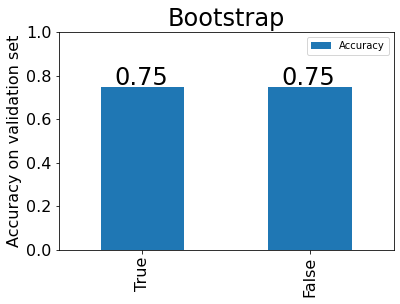

In [169]:
#Plotting the change in accuracy with bootstrap and without

X = trainingdata3_NaNs_replaced_mean.iloc[:,:-2]
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1]

bootstrap_to_test = [True,False]
accuracies = []

#Evaluating
for bootstrap in bootstrap_to_test:
  print(bootstrap)
  accuracy_tot = 0
  for i in range(10):
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5)
    rfc = RandomForestClassifier(n_estimators=450, bootstrap=bootstrap, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=6, n_jobs=-1).fit(X_train, Y_train.values.ravel())
    accuracy_tot += accuracy_score(Y_val,rfc.predict(X_val))
  accuracies.append(accuracy_tot/10)

#Plotting
df = pd.DataFrame({'Accuracy': accuracies,}, index=bootstrap_to_test)
bars = df.plot.bar(fontsize=16)
plt.title('Bootstrap',fontsize=24)
plt.ylim([0,1])
plt.ylabel('Accuracy on validation set',fontsize=16)
for i, v in enumerate(accuracies):
    plt.text(bootstrap_to_test[i] - 0.17, v + 0.01, str(round(v,2)),fontsize=24)
plt.show()

auto
sqrt


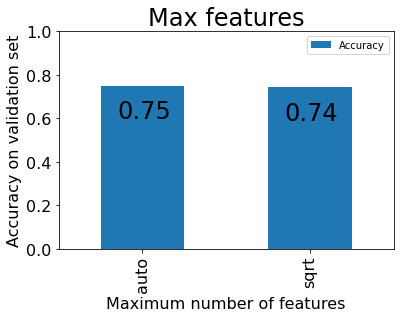

In [170]:
#Plotting the change in accuracy with the maximum number of features on automatic or squareroot

X = trainingdata3_NaNs_replaced_mean.iloc[:,:-2]
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1]

max_features_to_test = ['auto','sqrt']
accuracies = []

#Evaluating
for max_features in max_features_to_test:
  print(max_features)
  accuracy_tot = 0
  for i in range(10):
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5)
    rfc = RandomForestClassifier(n_estimators=450, bootstrap=False, max_depth=40, max_features=max_features, min_samples_leaf=1, min_samples_split=6, n_jobs=-1).fit(X_train, Y_train.values.ravel())
    accuracy_tot += accuracy_score(Y_val,rfc.predict(X_val))
  accuracies.append(accuracy_tot/10)

#Plotting
df = pd.DataFrame({'Accuracy': accuracies,}, index=max_features_to_test)
bars = df.plot.bar(fontsize=16)
plt.title('Max features',fontsize=24)
plt.xlabel('Maximum number of features',fontsize=16)
plt.ylabel('Accuracy on validation set',fontsize=16)
plt.ylim([0.0,1.0])
pos_for_plot = [0.1,1.1]
for i, v in enumerate(accuracies):
    plt.text(pos_for_plot[i]-0.25, v + -0.15, str(round(v,2)),fontsize=24)
plt.show()

1
2
3
4
5
6
7
8
9
10


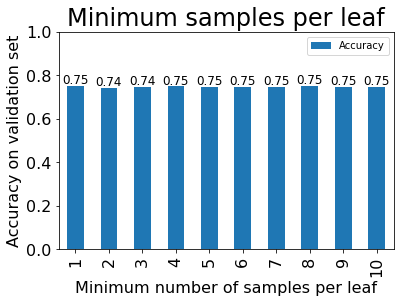

In [171]:
#Plotting the change in accuracy with the increase in the minimum of samples per leaf

X = trainingdata3_NaNs_replaced_mean.iloc[:,:-2]
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1]

min_samples_leaf_to_test = [1,2,3,4,5,6,7,8,9,10]
accuracies = []

#Evaluating
for min_samples_leaf in min_samples_leaf_to_test:
  print(min_samples_leaf)
  accuracy_tot = 0
  for i in range(10):
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5)
    rfc = RandomForestClassifier(n_estimators=450, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=min_samples_leaf, min_samples_split=6, n_jobs=-1).fit(X_train, Y_train.values.ravel())
    accuracy_tot += accuracy_score(Y_val,rfc.predict(X_val))
  accuracies.append(accuracy_tot/10)

#Plotting
df = pd.DataFrame({'Accuracy': accuracies,}, index=min_samples_leaf_to_test)
bars = df.plot.bar(fontsize=16)
plt.title('Minimum samples per leaf',fontsize=24)
plt.xlabel('Minimum number of samples per leaf',fontsize=16)
plt.ylabel('Accuracy on validation set',fontsize=16)
plt.ylim([0.0,1.0])
for i, v in enumerate(accuracies):
    plt.text(min_samples_leaf_to_test[i]-1.4, v + 0.01, str(round(v,2)),fontsize=12)
plt.show()

2
3
4
5
6
7
8
9
10
11
12
13
14
15


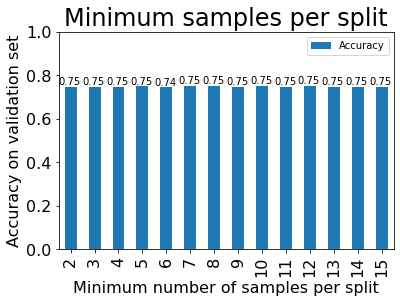

In [172]:
#Plotting the change in accuracy with the increase in the minimum of samples per split

X = trainingdata3_NaNs_replaced_mean.iloc[:,:-2]
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1]

min_samples_split_to_test = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
accuracies = []

#Evaluating
for min_samples_split in min_samples_split_to_test:
  print(min_samples_split)
  accuracy_tot = 0
  for i in range(10):
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5)
    rfc = RandomForestClassifier(n_estimators=450, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=min_samples_split, n_jobs=-1).fit(X_train, Y_train.values.ravel())
    accuracy_tot += accuracy_score(Y_val,rfc.predict(X_val))
  accuracies.append(accuracy_tot/10)

#Plotting
df = pd.DataFrame({'Accuracy': accuracies,}, index=min_samples_split_to_test)
bars = df.plot.bar(fontsize=16)
plt.title('Minimum samples per split',fontsize=24)
plt.xlabel('Minimum number of samples per split',fontsize=16)
plt.ylabel('Accuracy on validation set',fontsize=16)
plt.ylim([0.0,1.0])
for i, v in enumerate(accuracies):
    plt.text(min_samples_split_to_test[i]-2.5, v + 0.01, str(round(v,2)),fontsize=10)
plt.show()

10
50
100
150
250
350
450
550
650


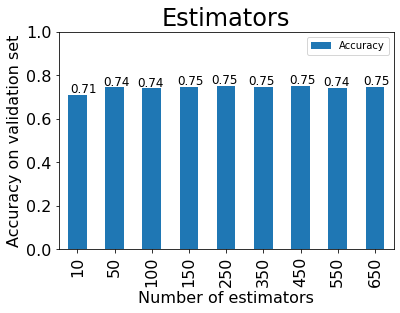

In [173]:
#Plotting the change in accuracy as number of estimators increase
X = trainingdata3_NaNs_replaced_mean.iloc[:,:-2]
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1]

n_estimators_to_test = [10,50,100,150,250,350,450,550,650]
accuracies = []

#Evaluating
for n_estimators in n_estimators_to_test:
  print(n_estimators)
  accuracy_tot = 0
  for i in range(10):
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5)
    rfc = RandomForestClassifier(n_estimators=n_estimators, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=6, n_jobs=-1).fit(X_train, Y_train.values.ravel())
    accuracy_tot += accuracy_score(Y_val,rfc.predict(X_val))
  accuracies.append(accuracy_tot/10)

#Plotting
df = pd.DataFrame({'Accuracy': accuracies,}, index=n_estimators_to_test)
bars = df.plot.bar(fontsize=16)
plt.title('Estimators',fontsize=24)
plt.xlabel('Number of estimators',fontsize=16)
plt.ylabel('Accuracy on validation set',fontsize=16)
plt.ylim([0.0,1.0])
    
plt.text(-0.2, accuracies[0] + 0.01, str(round(accuracies[0],2)),fontsize=12)
plt.text(0.7, accuracies[1] + 0.01, str(round(accuracies[1],2)),fontsize=12)
plt.text(1.6, accuracies[2] + 0.01, str(round(accuracies[2],2)),fontsize=12)
plt.text(2.7, accuracies[3] + 0.01, str(round(accuracies[3],2)),fontsize=12)
plt.text(3.6, accuracies[4] + 0.01, str(round(accuracies[4],2)),fontsize=12)
plt.text(4.6, accuracies[5] + 0.01, str(round(accuracies[5],2)),fontsize=12)
plt.text(5.7, accuracies[6] + 0.01, str(round(accuracies[6],2)),fontsize=12)
plt.text(6.6, accuracies[7] + 0.01, str(round(accuracies[7],2)),fontsize=12)
plt.text(7.7, accuracies[8] + 0.01, str(round(accuracies[8],2)),fontsize=12)

plt.show()

0.1
0.2
0.3
0.4
0.5


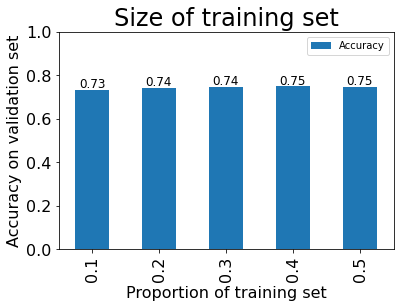

In [174]:
#Plot to check how accuracy increases as the number of samples considered increases

X = trainingdata3_NaNs_replaced_mean.iloc[:,:-2]
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1]

train_sizes_to_test = [0.1,0.2,0.3,0.4,0.5]
accuracies = []

#Evaluating
for train_size in train_sizes_to_test:
  print(train_size)
  accuracy_tot = 0
  for i in range(10):
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=(1-train_size))
    rfc = RandomForestClassifier(n_estimators=450, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=6, n_jobs=-1).fit(X_train, Y_train.values.ravel())
    accuracy_tot += accuracy_score(Y_val,rfc.predict(X_val))
  accuracies.append(accuracy_tot/10)

#Plotting
df = pd.DataFrame({'Accuracy': accuracies,}, index=train_sizes_to_test)
bars = df.plot.bar(fontsize=16)
plt.title('Size of training set',fontsize=24)
plt.xlabel('Proportion of training set',fontsize=16)
plt.ylabel('Accuracy on validation set',fontsize=16)
plt.ylim([0.0,1.0])

plt.text(-0.2, accuracies[0] + 0.01, str(round(accuracies[0],2)),fontsize=12)
plt.text(0.8, accuracies[1] + 0.01, str(round(accuracies[1],2)),fontsize=12)
plt.text(1.8, accuracies[2] + 0.01, str(round(accuracies[2],2)),fontsize=12)
plt.text(2.8, accuracies[3] + 0.01, str(round(accuracies[3],2)),fontsize=12)
plt.text(3.8, accuracies[4] + 0.01, str(round(accuracies[4],2)),fontsize=12)

plt.show()

We use the above results to define the best hyperparameters to use for our RFC. We found the following: 450 estimators, no bootstrapping, 40 for the maximum depth of the trees, square-root for defining the maximum number of features for a split, 1 for the minimum number of samples per leaf and 6 for the minimum number of samples per split in each decision tree.

##5. Final model and its evaluation

In [175]:
#Our final model

#Getting the data
X = trainingdata3_NaNs_replaced_mean.iloc[:,:-2] #Features
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1] #Labels (0 or 1)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5) #Splitting the data

#Fitting and evaluating it
rfc = RandomForestClassifier(n_estimators=450, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=6, n_jobs=-1).fit(X_train, Y_train.values.ravel())
accuracy = accuracy_score(Y_val,rfc.predict(X_val))
print('The accuracy of our final model with', accuracy)

The accuracy of our final model with 0.7494117647058823


In [176]:
#Evaluating the accuracy of our model over 5 runs

X = trainingdata3_NaNs_replaced_mean.iloc[:,:-2] #Features
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1] #Labels (0 or 1)

accuracy_total = 0
for i in range(5):
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5) #Splitting the data
  rfc = RandomForestClassifier(n_estimators=450, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=6, n_jobs=-1).fit(X_train, Y_train.values.ravel())
  accuracy_total += accuracy_score(Y_val,rfc.predict(X_val))

print('The accuracy of our final model averaged over 5 runs is', accuracy_total/5)

The accuracy of our final model averaged over 5 runs is 0.7550588235294118


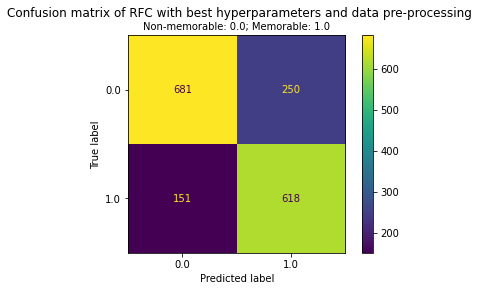

In [177]:
#Printing the confusion matrix of our model

predictions = rfc.predict(X_val)
cm = confusion_matrix(Y_val, predictions, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)
disp.plot()
plt.suptitle('Confusion matrix of RFC with best hyperparameters and data pre-processing')
plt.title('Non-memorable: 0.0; Memorable: 1.0',fontsize=10)
plt.show()

In [178]:
#Printing the evaluation metrics of our model

print('Accuracy:',accuracy_score(Y_val, predictions))
print('Pos precision',precision_score(Y_val, predictions,pos_label=1))
print('Neg precision',precision_score(Y_val,predictions,pos_label=0))
print('Recall sensitivity', recall_score(Y_val, predictions, pos_label=1))
print('Recall specificity', recall_score(Y_val, predictions, pos_label=0))
print('F1 positive', f1_score(Y_val, predictions, pos_label=1))
print('F1 negative', f1_score(Y_val, predictions, pos_label=0))

Accuracy: 0.7641176470588236
Pos precision 0.7119815668202765
Neg precision 0.8185096153846154
Recall sensitivity 0.8036410923276983
Recall specificity 0.7314715359828142
F1 positive 0.7550397067806963
F1 negative 0.7725467952353943


Next we will explore if our model fails more on confident or unconfident data.

In [285]:
#Does our model fail more on confident or unconfident data?

#Getting the data
X = trainingdata3_NaNs_replaced_mean.iloc[:,:-2] #Features
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1] #Labels (0 or 1)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5) #Splitting the data

#Fitting our classifier
rfc = RandomForestClassifier(n_estimators=450, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=6, n_jobs=-1).fit(X_train, Y_train.values.ravel())

#Getting the predictions and confidence of each to explore
predictions = np.array(rfc.predict(X_val))
groundtruth = np.reshape(np.array(Y_val),(len(Y_val)))
index = sorted(list(X_val.index))
confidence = list(trainingdata3_NaNs_replaced_mean.iloc[index,-1])


Accuracy on confident data: 0.7871396895787139


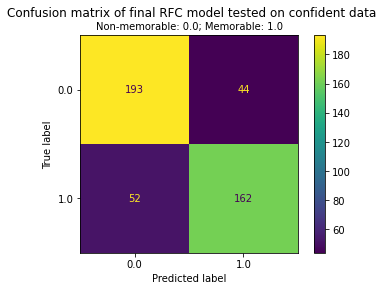

Accuracy on unconfident data: 0.7309847878302642


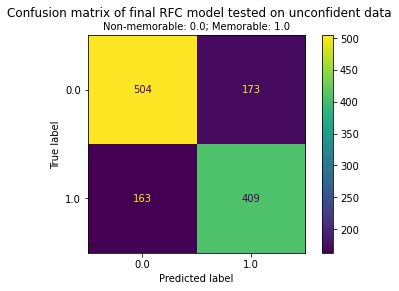

451 1249


In [284]:
#Print confusion matrix for our model on confident data
X_val_confident = X_val[trainingdata3_NaNs_replaced_mean['confidence'] == 1]
Y_val_confident = Y_val[trainingdata3_NaNs_replaced_mean['confidence'] == 1]
predictions = rfc.predict(X_val_confident)
print('Accuracy on confident data:',accuracy_score(Y_val_confident,predictions))
cm = confusion_matrix(Y_val_confident, predictions, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)
disp.plot()
plt.suptitle('Confusion matrix of final RFC model tested on confident data')
plt.title('Non-memorable: 0.0; Memorable: 1.0',fontsize=10)
plt.show()

#Print confusion matrix for our model on unconfident data
X_val_unconfident = X_val[trainingdata3_NaNs_replaced_mean['confidence'] == 0.66]
Y_val_unconfident = Y_val[trainingdata3_NaNs_replaced_mean['confidence'] == 0.66]
predictions = rfc.predict(X_val_unconfident)
print('Accuracy on unconfident data:',accuracy_score(Y_val_unconfident,predictions))
cm = confusion_matrix(Y_val_unconfident, predictions, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)
disp.plot()
plt.suptitle('Confusion matrix of final RFC model tested on unconfident data')
plt.title('Non-memorable: 0.0; Memorable: 1.0',fontsize=10)
plt.show()

In [255]:
num_confident_samples = len(trainingdata3[trainingdata3['confidence'] == 1.00])
num_unconfident_samples = len(trainingdata3[trainingdata3['confidence'] == 0.66])
print('There are {} confident samples and {} un-confident samples'.format(num_confident_samples,num_unconfident_samples))
print('{}% are unconfident'.format(round(num_unconfident_samples*100/(num_confident_samples+num_unconfident_samples),2)))

There are 899 confident samples and 2501 un-confident samples
73.56% are unconfident


##6. Making our predictions

Steps to make our prediction:
1. Prepare the data that we will make the predictions on
2. Prepare the model that we will use to make the predictions
3. Make the predictions
4. Store the predictions in a CSV file

In [269]:
#We will first prepare the test data for the predictions

#Inpute the missing values with the mean
testdata_replaced_mean = testdata.copy()
for feature_name in feature_names:
  testdata_replaced_mean[feature_name] = testdata_replaced_mean[feature_name].replace(np.NaN, testdata_replaced_mean[feature_name].mean())

In [259]:
#Now we will prepare our model, getting the data and fitting it
X = trainingdata3_NaNs_replaced_mean.iloc[:,:-2] #Features
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1] #Labels (0 or 1)
rfc = RandomForestClassifier(n_estimators=450, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=6, n_jobs=-1).fit(X, Y.values.ravel())

In [270]:
#Make the predictions
testdata_predictions = rfc.predict(testdata_replaced_mean)

In [271]:
#Store in predictions.csv
pd.DataFrame(testdata_predictions).to_csv('predictions.csv')

##7. Experimentations with other classifiers

This section is used to show the other classifiers we experimented with (on other notebooks mostly) to show that for this dataset, they do not perform as well as RFC).

In [274]:
from sklearn import svm

#Get tje data
X = trainingdata3_NaNs_replaced_mean.iloc[:,:-2] #Features
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1] #Labels (0 or 1)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5) #Splitting the data

#Evaluate the model
accuracy_total = 0
f1_total = 0
for i in range(10):
  #Initialising and fitting
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5) #Splitting the data
  svc_model = svm.SVC(kernel='linear').fit(X_train, Y_train.values.ravel())

  #Get metrics
  accuracy, precision, recall, f1 = get_metrics(svc_model,X_val,Y_val)
  accuracy_total += accuracy
  f1_total += f1

baseline_accuracy = accuracy_total/10
baseline_f1 = f1_total/10
baseline_data = [["Accuracy", baseline_accuracy],
                 ["F1", baseline_f1]]

#Pring the average metrics in a table
print('The metrics of our SVC model averaged over 10 runs:')
print(tabulate(baseline_data, headers=['Metric','Value'], tablefmt="fancy_grid"))

The metrics of our SVC model averaged over 10 runs:
╒══════════╤══════════╕
│ Metric   │    Value │
╞══════════╪══════════╡
│ Accuracy │ 0.658176 │
├──────────┼──────────┤
│ F1       │ 0.626931 │
╘══════════╧══════════╛


In [275]:
from sklearn.cluster import KMeans

#Getting the data
X = trainingdata3_NaNs_replaced_mean.iloc[:,:-2] #Features
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1] #Labels (0 or 1)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5) #Splitting the data

#Evaluating the model
accuracy_total = 0
f1_total = 0
for i in range(10):
  #Initialising and fitting
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5) #Splitting the data
  kmeans_model = KMeans(n_clusters=2).fit(X_train, Y_train.values.ravel())

  #Get metrics
  accuracy, precision, recall, f1 = get_metrics(kmeans_model,X_val,Y_val)
  accuracy_total += accuracy
  f1_total += f1

baseline_accuracy = accuracy_total/10
baseline_f1 = f1_total/10
baseline_data = [["Accuracy", baseline_accuracy],
                 ["F1", baseline_f1]]

#Pring the average metrics in a table
print('The metrics of our KMeans model averaged over 10 runs:')
print(tabulate(baseline_data, headers=['Metric','Value'], tablefmt="fancy_grid"))

The metrics of our KMeans model averaged over 10 runs:
╒══════════╤══════════╕
│ Metric   │    Value │
╞══════════╪══════════╡
│ Accuracy │ 0.459765 │
├──────────┼──────────┤
│ F1       │ 0.475598 │
╘══════════╧══════════╛


In [276]:
from sklearn.ensemble import GradientBoostingClassifier

#Getting the data
X = trainingdata3_NaNs_replaced_mean.iloc[:,:-2] #Features
Y = trainingdata3_NaNs_replaced_mean.iloc[:,-2:-1] #Labels (0 or 1)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5) #Splitting the data

#Evaluating the model
accuracy_total = 0
f1_total = 0
for i in range(10):
  #Initialising and fitting
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5) #Splitting the data
  gbc_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1).fit(X_train, Y_train.values.ravel())

  #Get metrics
  accuracy, precision, recall, f1 = get_metrics(gbc_model,X_val,Y_val)
  accuracy_total += accuracy
  f1_total += f1

baseline_accuracy = accuracy_total/10
baseline_f1 = f1_total/10
baseline_data = [["Accuracy", baseline_accuracy],
                 ["F1", baseline_f1]]

#Pring the average metrics in a table
print('The metrics of our Gradient Boosting classifier model averaged over 10 runs:')
print(tabulate(baseline_data, headers=['Metric','Value'], tablefmt="fancy_grid"))

The metrics of our Gradient Boosting classifier model averaged over 10 runs:
╒══════════╤══════════╕
│ Metric   │    Value │
╞══════════╪══════════╡
│ Accuracy │ 0.666412 │
├──────────┼──────────┤
│ F1       │ 0.63404  │
╘══════════╧══════════╛
